In [2]:
import torch
import numpy as np
from create_dataset import ClimbingHoldDatasetPred, ClimbingHoldDataset
from torchvision import transforms
from PIL import Image, ImageOps, ImageDraw
import cv2
import os
import matplotlib.pyplot as plt

Color Moments
Color Histograms of Oriented Gradients

In [2]:
# Create the dataset
dataset = ClimbingHoldDatasetPred(annotations_dir="hold_preds", 
                               images_dir="data/images")

In [4]:
# Function to print one sample hold and its attributes
def print_sample_hold(sample):  

    # Denormalize the image
    mean = torch.tensor([0.485, 0.456, 0.406]).reshape(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).reshape(3,1,1)
    img = sample["image"] * std + mean
    img = img.clamp(0, 1)

    pil_img = transforms.ToPILImage()(img)

    display(pil_img)
    print("\nSample Hold:")
    print(f"Parent image id: {sample['parent_image_id']}")
    # print(f"Route ID: {sample_hold['route_id']}")
    # # print(f"Image shape: {sample['image'].shape}")
    # print(f"Hold Type (index): {sample_hold['type']}")
    # print(f"Hold Orientation (index): {sample_hold['orientation']}")

# # Print one sample hold from both training and validation sets
# print("\nSample Hold from Training Set:")
# print_sample_hold(dataset.holds[0])

HSV Color Model

In [5]:
def decode_coco_rle(rle):
    """
    Decodes COCO RLE mask (uncompressed) into a binary numpy mask.
    rle: dict with fields:
         - 'counts': list of run lengths
         - 'size': [height, width]
    Returns:
         2D binary mask numpy array (height x width)
    """
    counts = rle["counts"]
    h, w = rle["size"]

    # Create flat mask
    flat = np.zeros(h * w, dtype=np.uint8)

    idx = 0
    val = 0  # starts with background

    for count in counts:
        if val == 1:
            flat[idx:idx + count] = 1
        idx += count
        val = 1 - val  # switch 0 ↔ 1

    # Reshape to H×W
    return flat.reshape((h, w), order='F')

In [6]:
def hsv_color_model(annotation, images_dir):
    img_path = img_path = os.path.join(images_dir, annotation["image_id"])
    segmentation = annotation["segmentation"]

    img = Image.open(img_path).convert("RGB")
    img = ImageOps.exif_transpose(img)

    # Decode RLE mask
    mask = decode_coco_rle(segmentation)
    
    # Convert image to NumPy
    rgb = np.array(img)

    # overlay = rgb.copy()
        
    # choose overlay color (red)
    # overlay[mask == 1] = [255, 0, 0]

    # alpha = 0.9  # transparency
    # blended = (rgb * (1 - alpha) + overlay * alpha).astype(np.uint8)

    # plt.figure(figsize=(8, 8))
    # plt.imshow(blended)
    # plt.title("Image with Mask Overlay")
    # plt.axis("off")
    # plt.show()

    # Use mask to extract object pixels
    object_pixels = rgb[mask == 1]

    if len(object_pixels) == 0:
        return None  # no object pixels
    
    # Convert to HSV using OpenCV
    hsv = cv2.cvtColor(object_pixels.reshape(-1,1,3), cv2.COLOR_RGB2HSV)

    # Compute mean HSV
    mean_hsv = hsv.mean(axis=0).flatten()

    H_mean, S_mean, V_mean = mean_hsv.tolist()
    
    return H_mean, S_mean, V_mean

In [7]:
def visualize_hsv_color(mean_hsv):
    # mean_hsv = (H, S, V)
    H, S, V = mean_hsv

    # Create 1x1 HSV image
    hsv_pixel = np.uint8([[[H, S, V]]])  
    rgb_pixel = cv2.cvtColor(hsv_pixel, cv2.COLOR_HSV2RGB)[0,0]

    # Convert to PIL for display
    color_patch = Image.new("RGB", (200, 200), tuple(rgb_pixel.tolist()))
    display(color_patch)

In [8]:
def visualize_hue(mean_hsv):
    H = mean_hsv

    # Make a strip of HSV values where hue = your hue
    hsv_strip = np.zeros((50, 200, 3), dtype=np.uint8)
    hsv_strip[..., 0] = H      # Hue
    hsv_strip[..., 1] = 255    # Full saturation
    hsv_strip[..., 2] = 255    # Full brightness

    # Convert to RGB for proper display
    rgb_strip = cv2.cvtColor(hsv_strip, cv2.COLOR_HSV2RGB)

    plt.figure(figsize=(2,2))
    plt.imshow(rgb_strip)
    plt.title(f"Hue = {H:.1f}")
    plt.axis('off')
    plt.show()

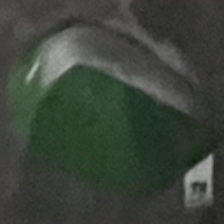


Sample Hold:
Parent image id: IMG_8281.jpeg


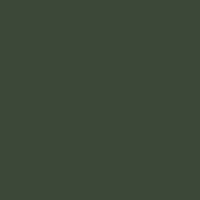

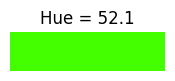

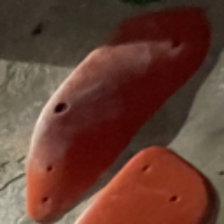


Sample Hold:
Parent image id: IMG_8281.jpeg


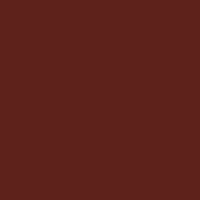

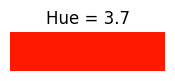

In [9]:
hold1 = 2
hold2 = 3

print_sample_hold(dataset[hold1])

h,s,v = hsv_color_model(dataset.holds[hold1], 'data/images')

visualize_hsv_color((h,s,v))
visualize_hue(h)

print_sample_hold(dataset[hold2])

h,s,v = hsv_color_model(dataset.holds[hold2], 'data/images')

visualize_hsv_color((h,s,v))
visualize_hue(h)

In [10]:
hues = []

for hold in dataset.holds:
    h, _, _ = hsv_color_model(hold, 'data/images')
    hues.append(h)

hues = np.array(hues)

np.save('hues.npy', hues)

In [27]:
def visualize_hues(hues):
    for H in hues[:100]:
        # Make a strip of HSV values where hue = your hue
        hsv_strip = np.zeros((50, 200, 3), dtype=np.uint8)
        hsv_strip[..., 0] = H      # Hue
        hsv_strip[..., 1] = 255    # Full saturation
        hsv_strip[..., 2] = 255    # Full brightness

        # Convert to RGB for proper display
        rgb_strip = cv2.cvtColor(hsv_strip, cv2.COLOR_HSV2RGB)

        plt.figure(figsize=(2,2))
        plt.imshow(rgb_strip)
        plt.title(f"Hue = {H:.1f}")
        plt.axis('off')
        plt.show()

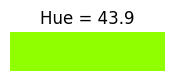

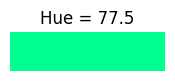

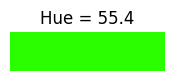

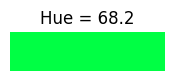

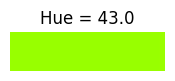

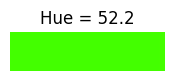

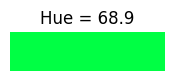

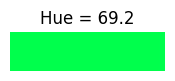

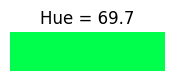

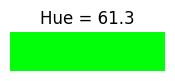

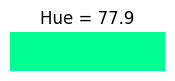

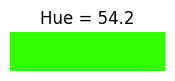

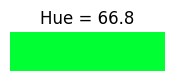

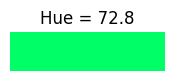

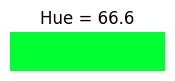

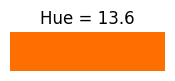

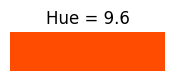

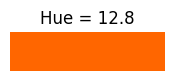

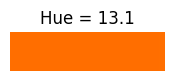

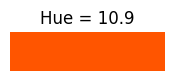

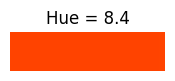

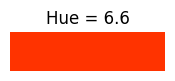

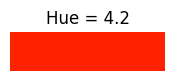

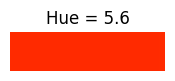

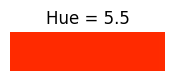

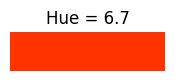

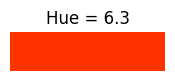

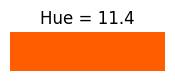

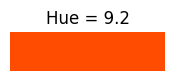

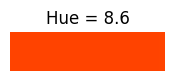

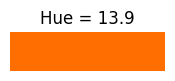

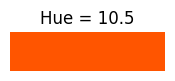

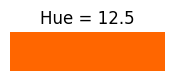

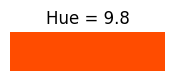

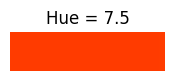

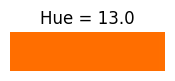

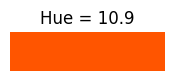

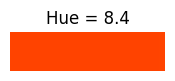

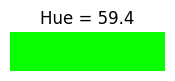

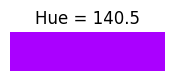

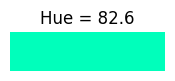

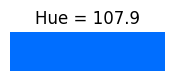

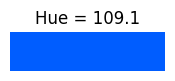

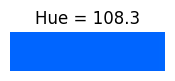

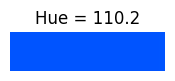

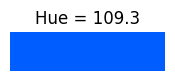

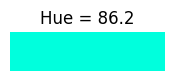

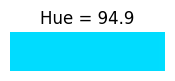

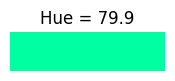

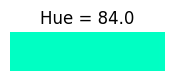

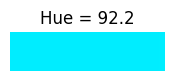

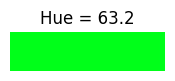

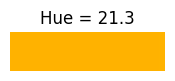

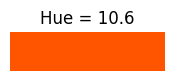

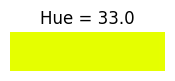

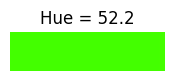

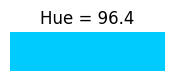

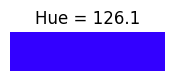

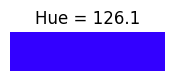

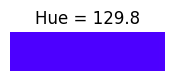

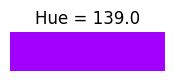

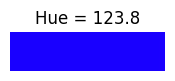

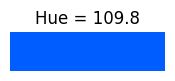

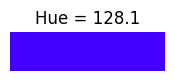

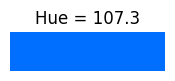

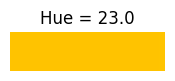

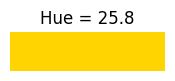

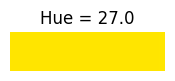

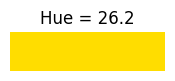

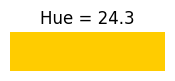

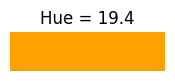

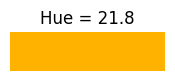

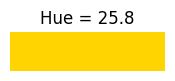

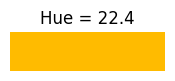

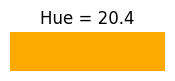

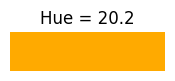

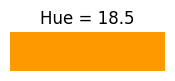

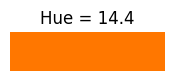

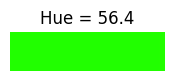

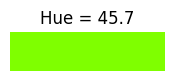

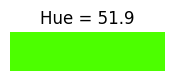

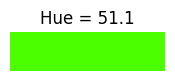

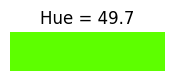

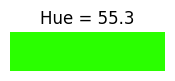

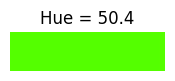

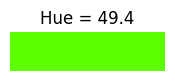

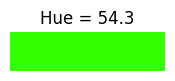

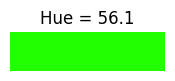

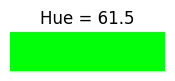

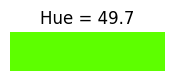

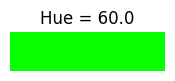

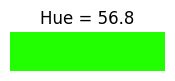

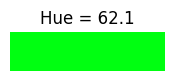

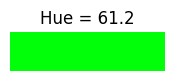

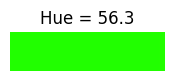

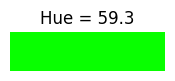

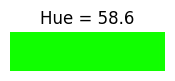

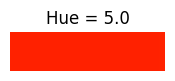

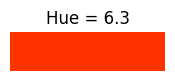

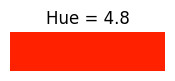

In [28]:
visualize_hues(hues)